### Song based sentiment analysis using Textblob

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

## Get a balanced sample of n songs per genre

In [3]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres
genres = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']
topic_columns = [i for i in range(0, num_topics)]
label_lookup = {
    0: "Country",
    1: "Electronic",
    2: "Folk",
    3: "Hip-Hop",
    4: "Indie",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "R&B",
    9: "Rock"
}

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,Just for you just for you that's why I say the...
1,Country,"Shirts in the closet, shoes in the hall Mama's..."
2,Country,From a jack to a king from loneliness to a wed...
3,Country,All gathered 'round in our Sunday best After t...
4,Country,What changed the look in his eyes? What made t...
5,Country,"I am a poor, wayfaring stranger Traveling thro..."
6,Country,Farther Along / Billy In the Low Ground Adrien...
7,Country,When I saw you standing there I bout fell out ...
8,Country,Can I depend on your light pretty moon while I...
9,Country,"It's a big house, With all this things you ass..."


## Remove punctuation/lower casing

In [5]:
song_data_processed = song_data.copy()
# removing everything except alphabets`
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("[^a-zA-Z#]", " ")
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("\'", " ")
# removing short words (shorter than 3 characters)
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: x.lower())
song_data_processed

,Genre,Lyrics
0,Country,just just that things things else make arms fe...
1,Country,"shirts closet, shoes hall mama kitchen, baby e..."
2,Country,from jack king from loneliness wedding ring pl...
3,Country,gathered round sunday best after service them ...
4,Country,what changed look eyes? what made change heart...
...,...,...
9995,Rock,shake shudder shiver bath while cold windows b...
9996,Rock,"there hasn been laughter this house long, just..."
9997,Rock,tell wrong. tell that knew along. roll over de...
9998,Rock,"well winding highway, that never seems end, we..."


## Remove stopwords and Tokenize

In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# tokenization
song_data_processed['Tokens'] = song_data_processed['Lyrics'].apply(lambda x: x.split())

# remove stop-words
song_data_processed['Tokens'] = song_data_processed['Tokens'].apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(song_data_processed)):
    t = ' '.join(song_data_processed['Tokens'][i])
    detokenized_doc.append(t)

song_data_processed['CleanLyrics'] = detokenized_doc
song_data_processed

,Genre,Lyrics,Tokens,CleanLyrics
0,Country,just just that things things else make arms fe...,"[things, things, else, make, arms, feel, like,...",things things else make arms feel like wrapped...
1,Country,"shirts closet, shoes hall mama kitchen, baby e...","[shirts, closet,, shoes, hall, mama, kitchen,,...","shirts closet, shoes hall mama kitchen, baby e..."
2,Country,from jack king from loneliness wedding ring pl...,"[jack, king, loneliness, wedding, ring, played...",jack king loneliness wedding ring played queen...
3,Country,gathered round sunday best after service them ...,"[gathered, round, sunday, best, service, churc...",gathered round sunday best service church step...
4,Country,what changed look eyes? what made change heart...,"[changed, look, eyes?, made, change, heart?, c...",changed look eyes? made change heart? changed ...
...,...,...,...,...
9995,Rock,shake shudder shiver bath while cold windows b...,"[shake, shudder, shiver, bath, cold, windows, ...",shake shudder shiver bath cold windows broken ...
9996,Rock,"there hasn been laughter this house long, just...","[laughter, house, long,, howling, wind, asking...","laughter house long, howling wind asking why. ..."
9997,Rock,tell wrong. tell that knew along. roll over de...,"[tell, wrong., tell, knew, along., roll, death...",tell wrong. tell knew along. roll death. know ...
9998,Rock,"well winding highway, that never seems end, we...","[well, winding, highway,, never, seems, end,, ...","well winding highway, never seems end, well mu..."


In [8]:
song_data_processed['Polarity'] = song_data_processed['CleanLyrics'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
song_data_processed['Subjectivity'] = song_data_processed['CleanLyrics'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [9]:
song_data_processed

,Genre,Lyrics,Tokens,CleanLyrics,Polarity,Subjectivity
0,Country,just just that things things else make arms fe...,"[things, things, else, make, arms, feel, like,...",things things else make arms feel like wrapped...,0.251818,0.530000
1,Country,"shirts closet, shoes hall mama kitchen, baby e...","[shirts, closet,, shoes, hall, mama, kitchen,,...","shirts closet, shoes hall mama kitchen, baby e...",-0.108333,0.100000
2,Country,from jack king from loneliness wedding ring pl...,"[jack, king, loneliness, wedding, ring, played...",jack king loneliness wedding ring played queen...,-0.098214,0.367063
3,Country,gathered round sunday best after service them ...,"[gathered, round, sunday, best, service, churc...",gathered round sunday best service church step...,-0.086012,0.541667
4,Country,what changed look eyes? what made change heart...,"[changed, look, eyes?, made, change, heart?, c...",changed look eyes? made change heart? changed ...,0.279545,0.519318
...,...,...,...,...,...,...
9995,Rock,shake shudder shiver bath while cold windows b...,"[shake, shudder, shiver, bath, cold, windows, ...",shake shudder shiver bath cold windows broken ...,-0.062857,0.541429
9996,Rock,"there hasn been laughter this house long, just...","[laughter, house, long,, howling, wind, asking...","laughter house long, howling wind asking why. ...",0.031250,0.375000
9997,Rock,tell wrong. tell that knew along. roll over de...,"[tell, wrong., tell, knew, along., roll, death...",tell wrong. tell knew along. roll death. know ...,-0.378164,0.668210
9998,Rock,"well winding highway, that never seems end, we...","[well, winding, highway,, never, seems, end,, ...","well winding highway, never seems end, well mu...",0.383333,0.629630


### Explore the results

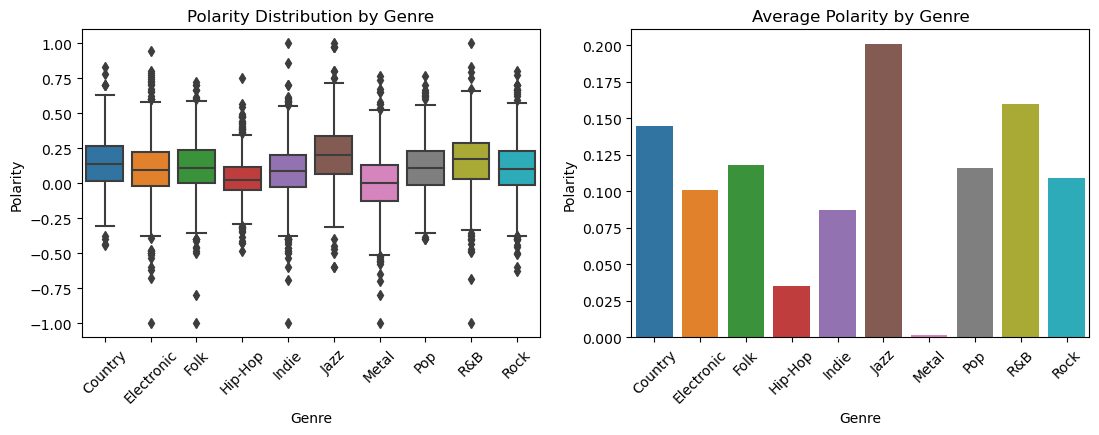

In [21]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
sns.boxplot(x='Genre', y='Polarity', data=song_data_processed)
plt.title('Polarity Distribution by Genre')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed


plt.subplot(1,2,2)
sns.barplot(x='Genre', y='Polarity', data=song_data_processed, errorbar=None)
plt.title('Average Polarity by Genre')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed

plt.show()

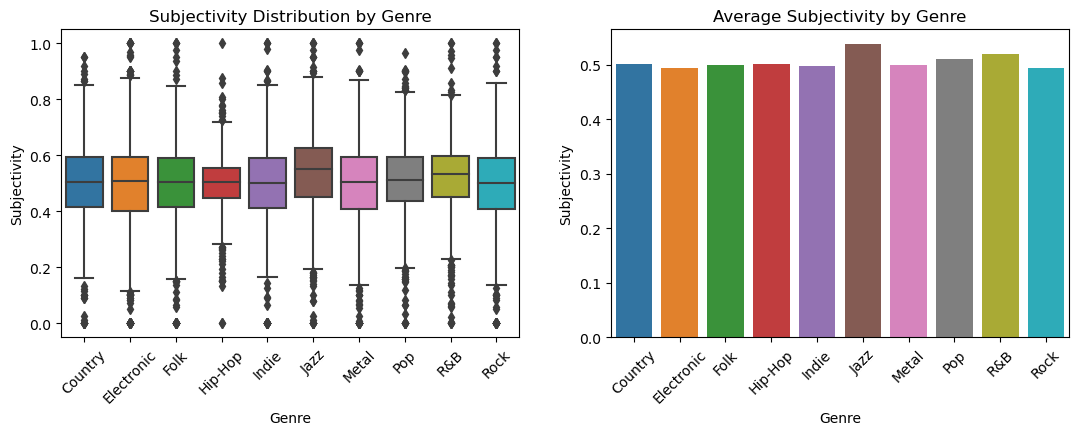

In [22]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
sns.boxplot(x='Genre', y='Subjectivity', data=song_data_processed)
plt.title('Subjectivity Distribution by Genre')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed


plt.subplot(1,2,2)
sns.barplot(x='Genre', y='Subjectivity', data=song_data_processed, errorbar=None)
plt.title('Average Subjectivity by Genre')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed

plt.show()

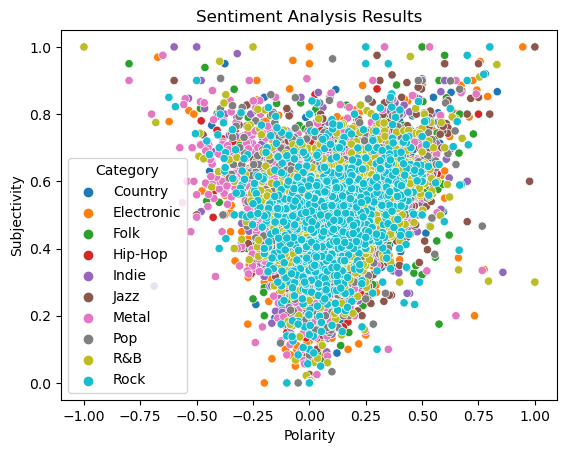

In [12]:
#Scatter Plot
sns.scatterplot(x='Polarity', y='Subjectivity', hue='Genre', data=song_data_processed)
plt.title('Sentiment Analysis Results')
plt.legend(title='Category')
plt.show()

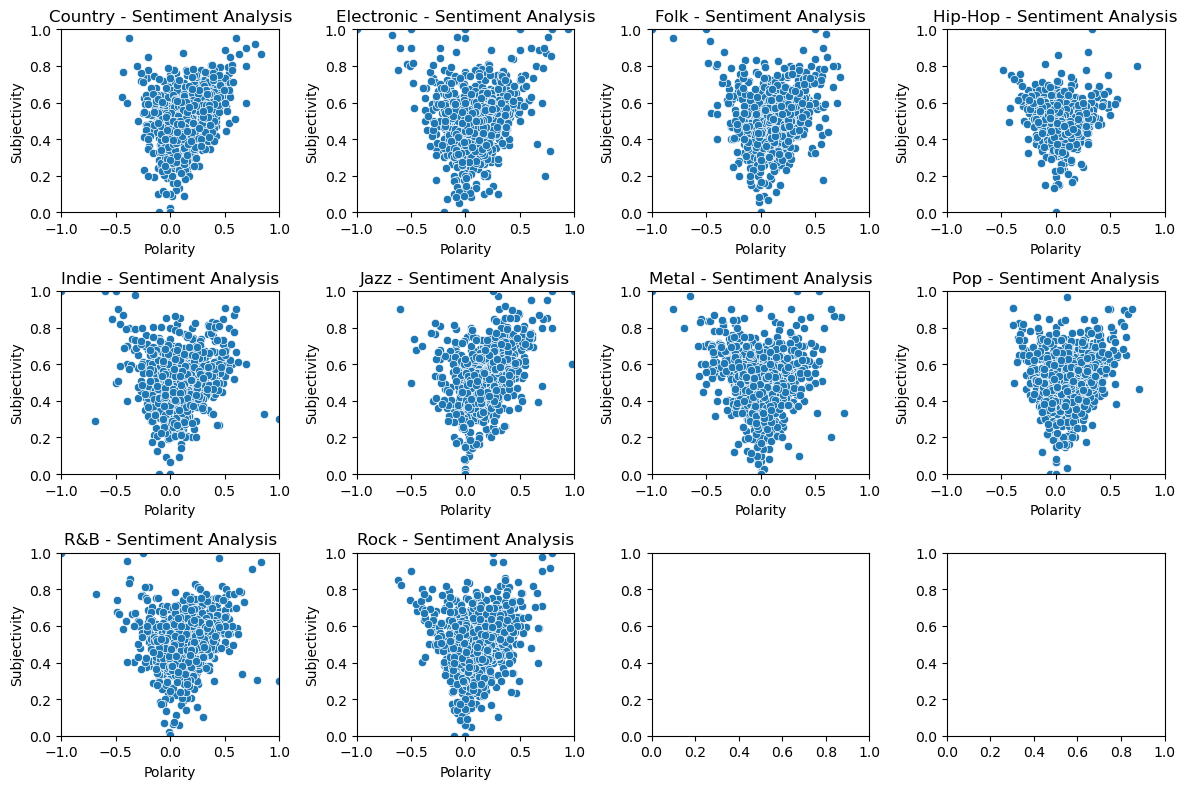

In [13]:
# Create the subplot figure
fig, axs = plt.subplots(3, 4, figsize=(12, 8))  # Adjust figsize as needed

# Iterate over genres and create scatter plots in each subplot
for i, genre in enumerate(genres):
    row = i // 4
    col = i % 4
    sns.scatterplot(x='Polarity', y='Subjectivity', data=song_data_processed[song_data_processed['Genre'] == genre], ax=axs[row][col])
    axs[row][col].set_title(f'{genre} - Sentiment Analysis')
    axs[row][col].set_xlim(-1, 1)  # Set x-axis limit
    axs[row][col].set_ylim(0, 1)  # Set y-axis limit

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Trying classification

In [14]:
X = song_data_processed[["Polarity", "Subjectivity"]]
label_encoder = LabelEncoder()
song_data_processed["GenreID"] = label_encoder.fit_transform(song_data_processed["Genre"])
y = song_data_processed["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.14066666666666666

In [16]:
#svm classifier
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.17466666666666666

In [17]:
#Random forest
rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.161

### Get Classification Matrix (of random forest)

In [18]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.11      0.03      0.04       318
           1       0.18      0.06      0.10       308
           2       0.07      0.05      0.06       288
           3       0.19      0.64      0.30       303
           4       0.00      0.00      0.00       320
           5       0.19      0.41      0.26       290
           6       0.21      0.29      0.24       292
           7       0.11      0.01      0.02       292
           8       0.18      0.19      0.19       324
           9       0.09      0.08      0.09       265

    accuracy                           0.17      3000
   macro avg       0.13      0.18      0.13      3000
weighted avg       0.13      0.17      0.13      3000



c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

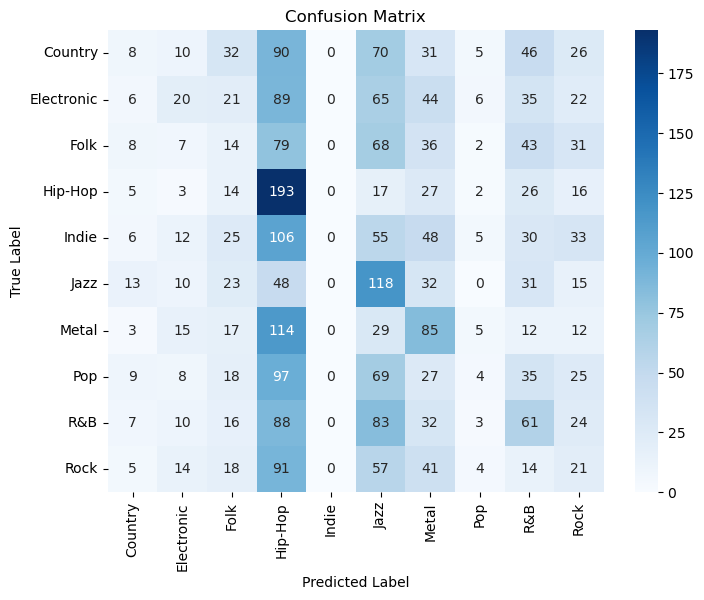

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = np.array([label_lookup.get(i) for i in svc.classes_])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
song_data_processed[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Electronic,1
2000,Folk,2
3000,Hip-Hop,3
4000,Indie,4
5000,Jazz,5
6000,Metal,6
7000,Pop,7
8000,R&B,8
9000,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Anwendung der sentiment analyse mithilfe der python textblob bibliothekt (Ergebnis in form von polarity & subjectivity)
- Investigating whether there is a correlation between the sentiments and the song genres, using boxplots, barcharts and Scatterplots
- Investigating whether it is possible to predict a genre based on its sentiments

### Ergebnis
- Die meisten songgenres können grundsätzlich positive als auch negative grundsentiments haben
- vor allem Metall und HipHop sind tendenziell eher negativer (was erwartungsgemäß ist), dieser unterschied ist jedoch nicht extrem groß
- Tendenziell sind song sentiments eher positiv
- Im bezug auf subjektivität sind die meisten songs eher neutral (und auch ähnlich neutral)
- Der Scatterplot zeigt, dass durch Sentiment und Subjektivität alleine keine differenzierung der songgenres möglich ist
- Dieses Ergebnis wird bestätigt durch die Anwendung verschiedener Klassifikationsverfahren, die maximal eine accuracy von 0.14 haben
- Bei Betrachtung der Confusion Matrix und des classification reports wird auch hier sichtbar, dass HipHop am besten predicted werden kann. Warum das so ist, kann allein durch betrachtung der Sentiment Analysis Daten allerdings nicht genau ermittelt werden.

### Interpretation
- Obwohl wenige genres tendenziell negativer sind, kann man grundsätzlich vom Song basierten sentiment nicht auf die gesamtheit eines genres schließen. dafür sind lieder innerhalb von genres zu unterschiedlich in ihrer grundstimmung
